In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
40534,NaN,NaN,International,2020-08-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40535,NaN,NaN,International,2020-08-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40536,NaN,NaN,International,2020-08-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


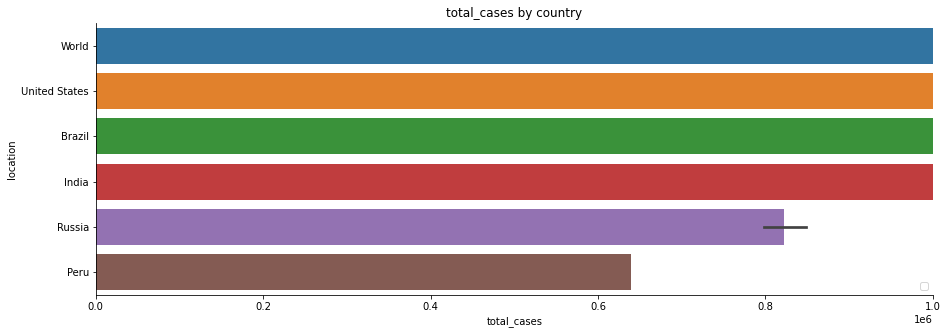

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


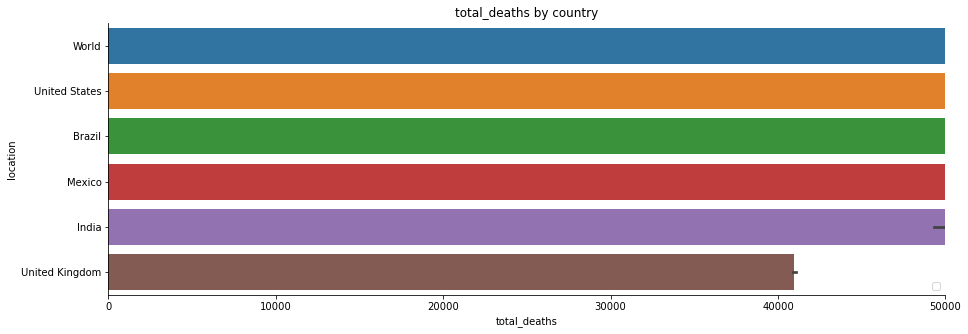

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


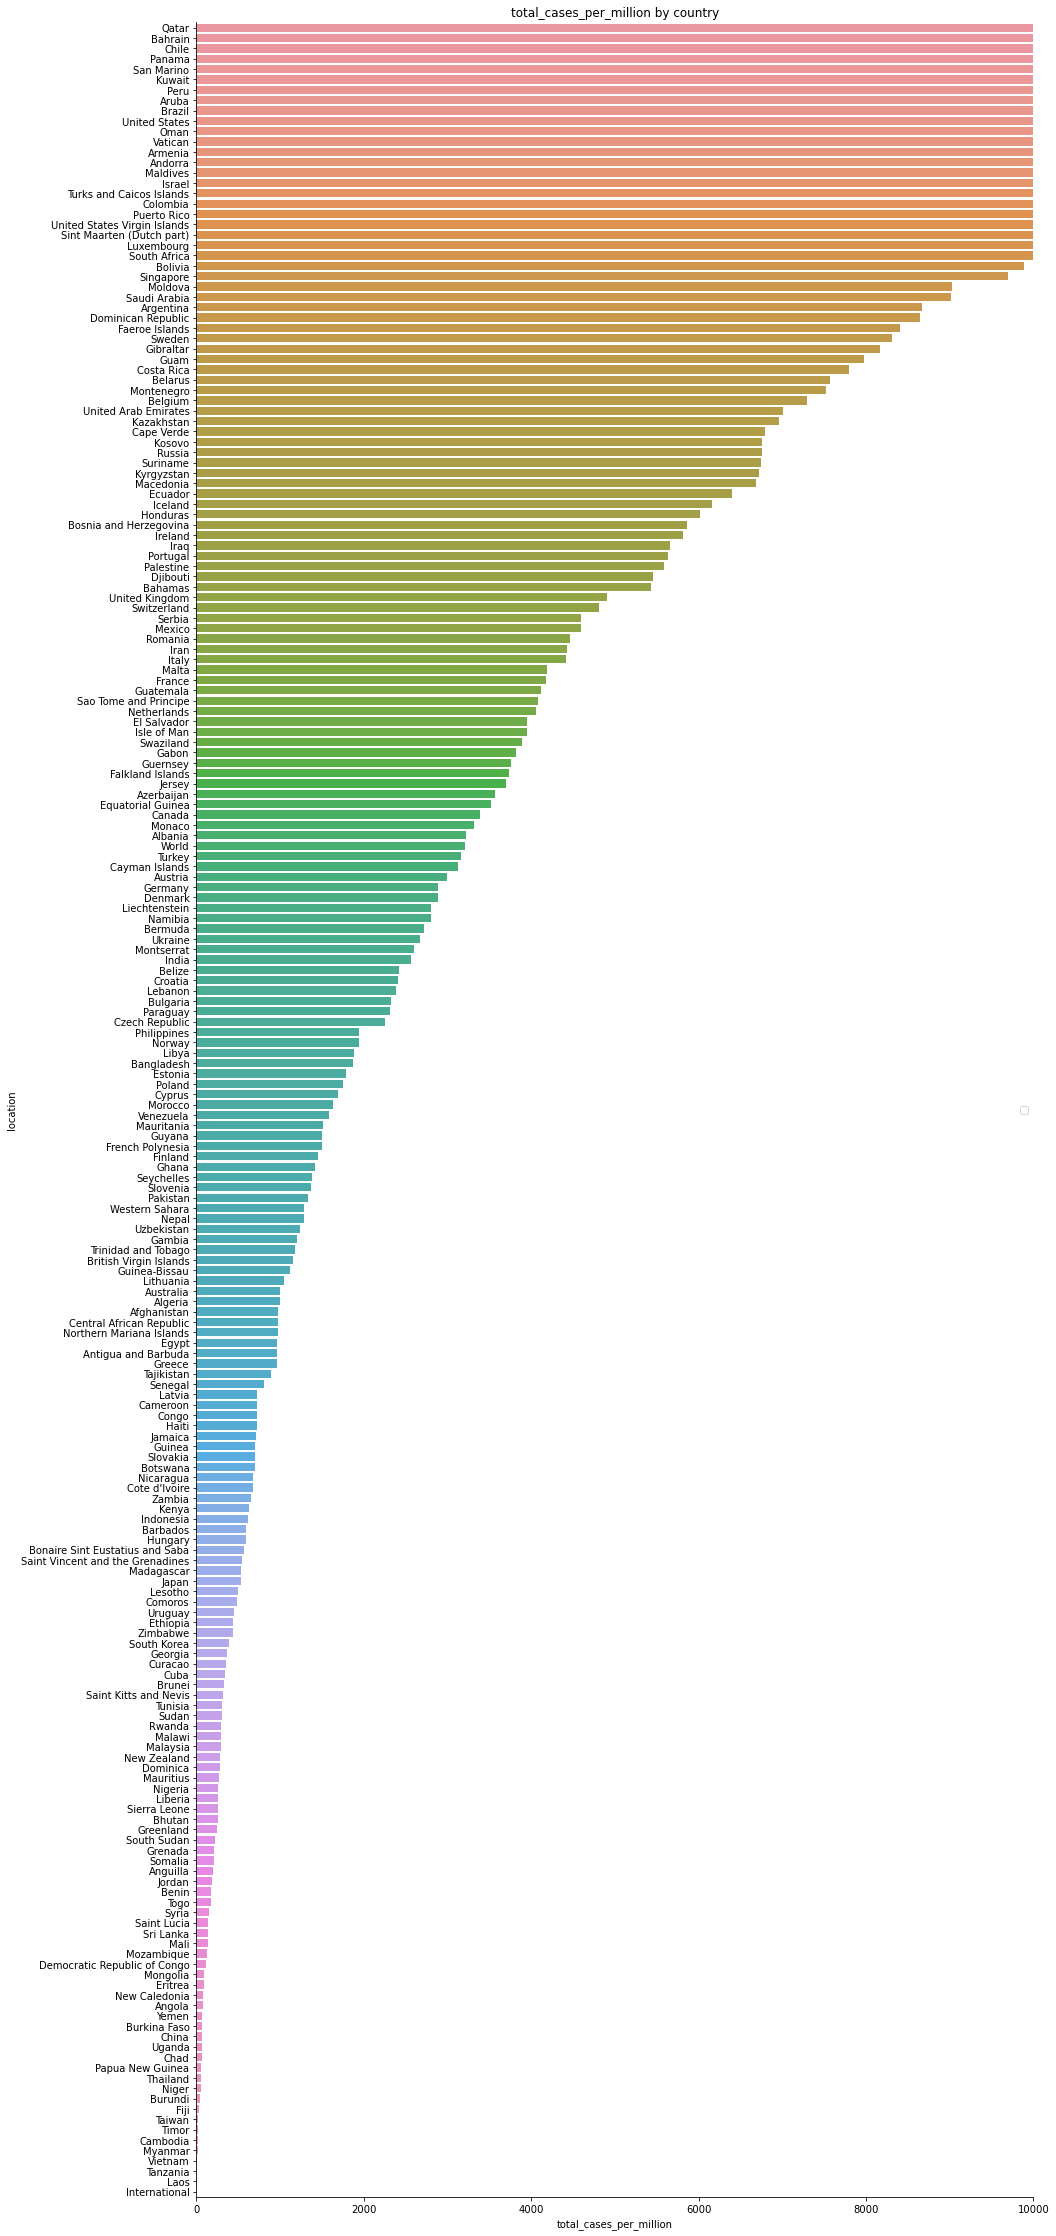

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


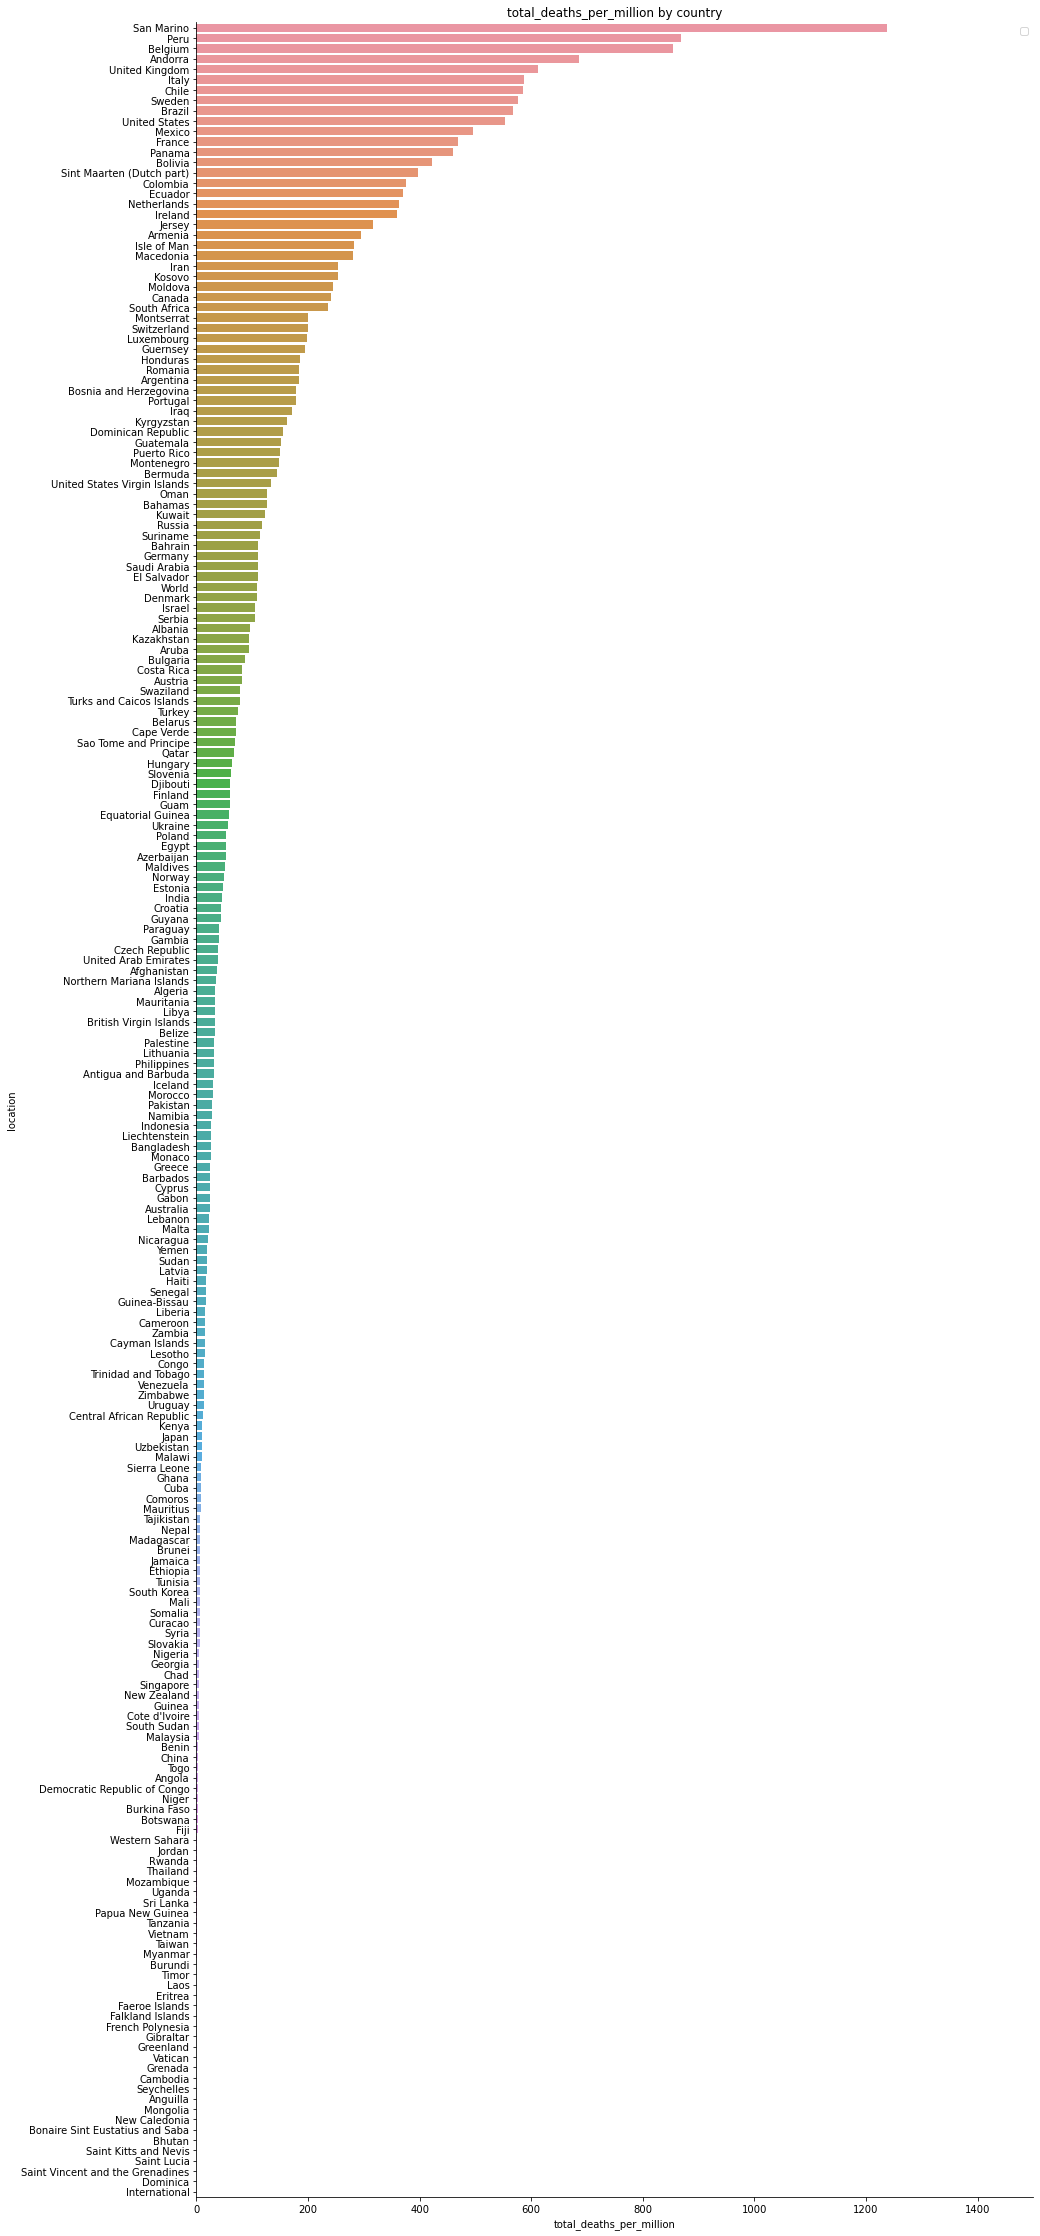

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

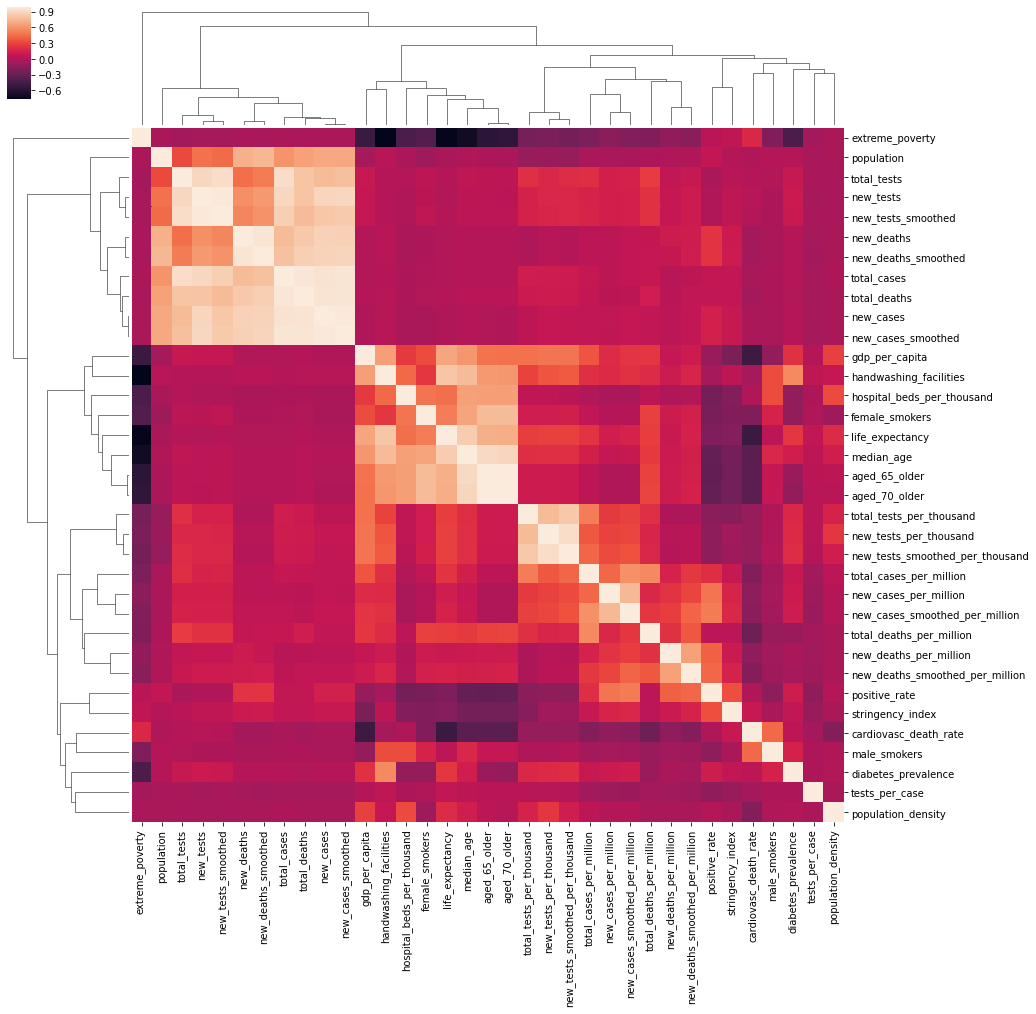

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994032620508828 (+/- 0.00046232591704190403)
Coef :  [1.03785432e+00 9.16841203e-05 9.54645019e-05]
3 Last_days :  [[24484592 24760720 25029408]]
Today :  25029408
Prediction + :  467636
Tomorow :  25497044
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996334188402578 (+/- 7.742745909435108e-05)
Coef :  [0.03645772 0.47145093 0.50233321]
3 Last_days :  [[832019 837476 843158]]
Today :  843158
Prediction + :  8093
Tomorow :  851251
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9945260478367307 (+/- 0.0020165972646629714)
Coef :  [-0.70541784  0.74121986  0.96644368]
3 Last_days :  [[259698 267077 272530]]
Today :  272530
Prediction + :  5808
Tomorow :  278338
                                     
--------- Total Death -----------------
                                     
R^2: 0.34499620175435314 (+/- 0.9165481686080347)
Coef :  [-0.75260782  0.78867731  0.96297531]
3 Last_days :  [[30576 30596 30602]]
Today :  30602
Prediction + :  37
Tomorow :  30639
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9053838392191697 (+/- 0.07222384164009915)
Coef :  [-0.32460784 -0.01992673  1.33880329]
3 Last_days :  [[89814 89836 89863]]
Today :  89863
Prediction + :  29
Tomorow :  89892
                                     
--------- Total Death -----------------
                                     
R^2: -224.9356820912045 (+/- 319.3687045837411)
Coef :  [-0.07697379  0.01244232  1.05645383]
3 Last_days :  [[4715 4718 4721]]
Today :  4721
Prediction + :  6
Tomorow :  4727
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5424232649377747 (+/- 0.6459124049455319)
Coef :  [-0.82891023  0.90060273  0.92760276]
3 Last_days :  [[263949 265409 266853]]
Today :  266853
Prediction + :  1298
Tomorow :  268151
                                     
--------- Total Death -----------------
                                     
R^2: 0.8199462158842401 (+/- 0.22828701385756517)
Coef :  [-0.8296389   0.90012056  0.92864329]
3 Last_days :  [[35463 35472 35473]]
Today :  35473
Prediction + :  29
Tomorow :  35502
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6657403573873172 (+/- 0.4636032604109759)
Coef :  [-0.58308061  0.43789034  1.14648661]
3 Last_days :  [[429507 439286 439286]]
Today :  439286
Prediction + :  6584
Tomorow :  445870
                                     
--------- Total Death -----------------
                                     
R^2: 0.16970773900045388 (+/- 0.9844670447964615)
Coef :  [-0.72409597  0.62310805  1.09997007]
3 Last_days :  [[28996 29011 29011]]
Today :  29011
Prediction + :  19
Tomorow :  29030
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9894111357879711 (+/- 0.014659909340751398)
Coef :  [0.07557157 0.46742599 0.47339284]
3 Last_days :  [[5867785 5917439 5961582]]
Today :  5961582
Prediction + :  83352
Tomorow :  6044934
                                     
--------- Total Death -----------------
                                     
R^2: 0.4413547347853215 (+/- 0.7885214869079149)
Coef :  [-0.54701443  0.73426201  0.81536371]
3 Last_days :  [[180824 181773 182779]]
Today :  182779
Prediction + :  1121
Tomorow :  183900
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9562168672968193 (+/- 0.06038887374636597)
Coef :  [-0.74315563  0.85899414  0.88429195]
3 Last_days :  [[330368 331644 332752]]
Today :  332752
Prediction + :  1364
Tomorow :  334116
                                     
--------- Total Death -----------------
                                     
R^2: 0.3886071515233165 (+/- 0.8310860163833802)
Coef :  [-0.77272321  0.83202327  0.94011673]
3 Last_days :  [[41477 41486 41498]]
Today :  41498
Prediction + :  43
Tomorow :  41541
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987769564772876 (+/- 0.0005038310428953551)
Coef :  [-0.79998757  0.85901507  0.94064152]
3 Last_days :  [[239507 240986 241771]]
Today :  241771
Prediction + :  1362
Tomorow :  243133
                                     
--------- Total Death -----------------
                                     
R^2: 0.3944881495269672 (+/- 0.844922405701966)
Coef :  [-0.79234232  0.84137103  0.95030047]
3 Last_days :  [[9288 9289 9295]]
Today :  9295
Prediction + :  7
Tomorow :  9302
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.2785025656041615 (+/- 3.2211367574282264)
Coef :  [0.22347254 0.39490656 0.39359287]
3 Last_days :  [[367796 369911 371816]]
Today :  371816
Prediction + :  4141
Tomorow :  375957
                                     
--------- Total Death -----------------
                                     
R^2: 0.9135923226859212 (+/- 0.12152060413519826)
Coef :  [0.01148871 0.50397145 0.49699108]
3 Last_days :  [[21137 21249 21359]]
Today :  21359
Prediction + :  258
Tomorow :  21617
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.99848345725764 (+/- 0.0018470754063356191)
Coef :  [-0.74060293  0.84986383  0.88808452]
3 Last_days :  [[263998 265515 267064]]
Today :  267064
Prediction + :  1256
Tomorow :  268320
                                     
--------- Total Death -----------------
                                     
R^2: 0.999070667636313 (+/- 0.0008031545049388783)
Coef :  [-0.81092263  0.89359763  0.91443023]
3 Last_days :  [[6209 6245 6284]]
Today :  6284
Prediction + :  29
Tomorow :  6313
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.45715142107647116 (+/- 0.7633584060654428)
Coef :  [-0.14465897  0.49906742  0.66224803]
3 Last_days :  [[3761391 3804803 3846153]]
Today :  3846153
Prediction + :  61777
Tomorow :  3907930
                                     
--------- Total Death -----------------
                                     
R^2: 0.4934753538252273 (+/- 0.7093178584688042)
Coef :  [-0.11605324  0.51949127  0.60939837]
3 Last_days :  [[118649 119504 120462]]
Today :  120462
Prediction + :  1513
Tomorow :  121975
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(25029408, 843158, 25497044, 851251),
 (272530, 30602, 278338, 30639),
 (266853, 35473, 268151, 35502),
 (439286, 29011, 445870, 29030),
 (5961582, 182779, 6044934, 183900),
 (89863, 4721, 89892, 4727),
 (332752, 41498, 334116, 41541),
 (241771, 9295, 243133, 9302),
 (371816, 21359, 375957, 21617),
 (267064, 6284, 268320, 6313),
 (3846153, 120462, 3907930, 121975)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-30,France,278338.0,0.0,30639.0,0.0,0.0,0.0
0,2020-08-30,China,89892.0,0.0,4727.0,0.0,0.0,0.0
0,2020-08-30,Italy,268151.0,0.0,35502.0,0.0,0.0,0.0
0,2020-08-30,Spain,445870.0,0.0,29030.0,0.0,0.0,0.0
0,2020-08-30,United States,6044934.0,0.0,183900.0,0.0,0.0,0.0
0,2020-08-30,World,25497044.0,0.0,851251.0,0.0,0.0,0.0
0,2020-08-30,United Kingdom,334116.0,0.0,41541.0,0.0,0.0,0.0
0,2020-08-30,Germany,243133.0,0.0,9302.0,0.0,0.0,0.0
0,2020-08-30,Iran,375957.0,0.0,21617.0,0.0,0.0,0.0
0,2020-08-30,Turkey,268320.0,0.0,6313.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")